# Importing Repositories

In [74]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize']=(20,10)

# Functions

In [75]:
def missing_zero_values_table(df): 
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Our selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    
        return mz_table

# Importing data files

## Paths for files

In [76]:
path_price = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadPrices_12.1.D'
path_totalload = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadTotalLoadForecast'
path_windsolar = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadGenerationForecastForWindAndSolar_14.1.D'

## Price Timeseries Importing

In [77]:

df_price = pd.read_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\price_timeseries_outliers.csv', 
parse_dates=['DateTime'])


In [78]:
df_price = df_price[['DateTime', 'Year', 'Month','Week', 'Day', 'Hour', 'Price', 'Outlier']]
df_price

DateTime  Year  Month  Week  Day  Hour  Price Outlier
0     2015-01-01 00:00:00  2015      1     1    3     0   0.00       N
1     2015-01-01 01:00:00  2015      1     1    3     1   0.00       N
2     2015-01-01 02:00:00  2015      1     1    3     2   0.00       N
3     2015-01-01 03:00:00  2015      1     1    3     3   0.00       N
4     2015-01-01 04:00:00  2015      1     1    3     4   0.00       N
...                   ...   ...    ...   ...  ...   ...    ...     ...
52529 2020-12-31 18:00:00  2020     12    53    3    18  71.30       N
52530 2020-12-31 19:00:00  2020     12    53    3    19  61.04       N
52531 2020-12-31 20:00:00  2020     12    53    3    20  60.39       N
52532 2020-12-31 21:00:00  2020     12    53    3    21  57.96       N
52533 2020-12-31 22:00:00  2020     12    53    3    22  55.02       N

[52534 rows x 8 columns]

## Wind and Solar Timeseries Importing

In [79]:
f_windsolar = glob.glob(path_windsolar + "/*.csv")
dwindsolar = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windsolar]

df_windsolar = pd.concat(dwindsolar)
df_windsolar = df_windsolar[df_windsolar['AreaCode'] == '10YGB----------A']
df_windsolar = df_windsolar[['DateTime', 'ProductionType', 'AggregatedGenerationForecast']]
df_windsolar.sort_values(by='DateTime', ascending=True)
df_windsolar.reset_index(drop=True, inplace=True)

In [80]:
df_windsolar

DateTime ProductionType  AggregatedGenerationForecast
0      2014-12-30 00:00:00          Solar                          0.00
1      2014-12-30 01:00:00          Solar                          0.00
2      2014-12-30 02:00:00          Solar                          0.00
3      2014-12-30 03:00:00          Solar                          0.00
4      2014-12-30 04:00:00          Solar                          0.00
...                    ...            ...                           ...
509107 2021-06-14 19:00:00  Wind Offshore                       1563.23
509108 2021-06-14 20:00:00  Wind Offshore                       1590.47
509109 2021-06-14 21:00:00  Wind Offshore                       1574.14
509110 2021-06-14 22:00:00  Wind Offshore                       1450.72
509111 2021-06-14 23:00:00  Wind Offshore                       1321.51

[509112 rows x 3 columns]

### Splitting the WindSolar Dataset into 3 Datasets per Solar, Wind Offshore, Wind Onshore

In [81]:
df_windsolar['ProductionType'].unique()

array(['Solar', 'Wind Offshore', 'Wind Onshore'], dtype=object)

In [82]:
df_solar = df_windsolar[df_windsolar['ProductionType'] == 'Solar']
df_solar.sort_values(by='DateTime', ascending=True)
df_solar.reset_index(drop=True, inplace=True)
df_solar.rename(columns={'AggregatedGenerationForecast':'SolarGeneration'}, inplace=True)
df_solar = df_solar[['DateTime','SolarGeneration']]
df_solar

DateTime  SolarGeneration
0      2014-12-30 00:00:00              0.0
1      2014-12-30 01:00:00              0.0
2      2014-12-30 02:00:00              0.0
3      2014-12-30 03:00:00              0.0
4      2014-12-30 04:00:00              0.0
...                    ...              ...
169699 2021-06-14 19:00:00            227.0
169700 2021-06-14 20:00:00             11.5
169701 2021-06-14 21:00:00              0.0
169702 2021-06-14 22:00:00              0.0
169703 2021-06-14 23:00:00              0.0

[169704 rows x 2 columns]

In [83]:
# Taking of the outliers
q1 , q3 = np.percentile(df_solar['SolarGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_solar = df_solar[(df_solar['SolarGeneration'] > ll) | (df_solar['SolarGeneration'] < ul) ]

In [84]:
df_wind_off = df_windsolar[df_windsolar['ProductionType'] == 'Wind Offshore']
df_wind_off.sort_values(by='DateTime', ascending=True)
df_wind_off.reset_index(drop=True, inplace=True)
df_wind_off.rename(columns={'AggregatedGenerationForecast':'WindOffGeneration'}, inplace=True)
df_wind_off = df_wind_off[['DateTime', 'WindOffGeneration']]
df_wind_off

DateTime  WindOffGeneration
0      2014-12-30 00:00:00             996.58
1      2014-12-30 01:00:00            1059.20
2      2014-12-30 02:00:00            1123.27
3      2014-12-30 03:00:00            1177.54
4      2014-12-30 04:00:00            1188.21
...                    ...                ...
169699 2021-06-14 19:00:00            1563.23
169700 2021-06-14 20:00:00            1590.47
169701 2021-06-14 21:00:00            1574.14
169702 2021-06-14 22:00:00            1450.72
169703 2021-06-14 23:00:00            1321.51

[169704 rows x 2 columns]

In [85]:
# Taking care of the outliers
q1 , q3 = np.percentile(df_wind_off['WindOffGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_wind_off = df_wind_off[(df_wind_off['WindOffGeneration'] > ll) | (df_wind_off['WindOffGeneration']) ]

In [86]:
df_wind_on = df_windsolar[df_windsolar['ProductionType'] == 'Wind Onshore']
df_wind_on.sort_values(by='DateTime', ascending=True)
df_wind_on.reset_index(drop=True, inplace=True)
df_wind_on.rename(columns={'AggregatedGenerationForecast':'WindOnGeneration'}, inplace=True)
df_wind_on = df_wind_on[['DateTime','WindOnGeneration']]
df_wind_on

DateTime  WindOnGeneration
0      2014-12-30 00:00:00           2363.80
1      2014-12-30 01:00:00           2413.88
2      2014-12-30 02:00:00           2450.75
3      2014-12-30 03:00:00           2500.78
4      2014-12-30 04:00:00           2536.07
...                    ...               ...
169699 2021-06-14 19:00:00           4896.71
169700 2021-06-14 20:00:00           3928.19
169701 2021-06-14 21:00:00           3277.03
169702 2021-06-14 22:00:00           2880.91
169703 2021-06-14 23:00:00           2492.04

[169704 rows x 2 columns]

In [87]:
# Taking care of the outliers
q1 , q3 = np.percentile(df_wind_on['WindOnGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_wind_on = df_wind_on[(df_wind_on['WindOnGeneration'] > ll) | (df_wind_on['WindOnGeneration']) ]

## Total Load Timeseries Importing

In [88]:
f_totalload = glob.glob(path_totalload + "/*.csv")
dtotalload = [pd.read_csv(f, encoding='utf-16', sep='\t', parse_dates=['DateTime']) for f in f_totalload]

df_totalload = pd.concat(dtotalload)
df_totalload = df_totalload[df_totalload['AreaCode'] == '10YGB----------A']
df_totalload = df_totalload[['DateTime', 'TotalLoadValue']]
df_totalload.reset_index(drop=True, inplace=True)


In [89]:
df_totalload.sort_values(by=['DateTime'], ascending=True)
df_totalload.reset_index(drop=True, inplace=True)
df_totalload

DateTime  TotalLoadValue
0      2014-12-29 00:00:00         28798.0
1      2014-12-29 02:00:00         29534.0
2      2014-12-29 00:30:00         29961.0
3      2014-12-29 02:30:00         29627.0
4      2014-12-29 04:30:00         26717.0
...                    ...             ...
202693 2020-09-30 14:30:00         34726.0
202694 2020-09-30 16:30:00         36430.0
202695 2020-09-30 18:30:00         36366.0
202696 2020-09-30 20:30:00         29449.0
202697 2020-09-30 22:30:00         22858.0

[202698 rows x 2 columns]

# Merging Datasets

In [90]:
df_price = df_price[df_price['Outlier'] == 'N']
df_merged = pd.merge(df_price, df_solar, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_off, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_on, how='left', on='DateTime')

In [91]:
df_merged.drop_duplicates(subset=['DateTime'], keep='first', inplace=True)

In [92]:
df_model = pd.DataFrame()
df_model = df_merged[['Price','Year', 'Month', 'Day', 'Hour', 'SolarGeneration', 'WindOffGeneration',
'WindOnGeneration']]
df_model.set_index(df_merged['DateTime'], inplace=True)
df_model

Price  Year  Month  Day  Hour  SolarGeneration  \
DateTime                                                              
2015-01-01 00:00:00   0.00  2015      1    3     0              0.0   
2015-01-01 01:00:00   0.00  2015      1    3     1              0.0   
2015-01-01 02:00:00   0.00  2015      1    3     2              0.0   
2015-01-01 03:00:00   0.00  2015      1    3     3              0.0   
2015-01-01 04:00:00   0.00  2015      1    3     4              0.0   
...                    ...   ...    ...  ...   ...              ...   
2020-12-31 18:00:00  71.30  2020     12    3    18              0.0   
2020-12-31 19:00:00  61.04  2020     12    3    19              0.0   
2020-12-31 20:00:00  60.39  2020     12    3    20              0.0   
2020-12-31 21:00:00  57.96  2020     12    3    21              0.0   
2020-12-31 22:00:00  55.02  2020     12    3    22              0.0   

                     WindOffGeneration  WindOnGeneration  
DateTime                                                  
2015-01-01 00:00:00            2987.05           4013.58  
2015-01-01 01:00:00            2926.71           4074.53  
2015-01-01 02:00:00            2867.00           4157.48  
2015-01-01 03:00:00            2808.72           4229.50  
2015-01-01 04:00:00            2769.59           4133.56  
...                                ...               ...  
2020-12-31 18:00:00            2644.97           3028.41  
2020-12-31 19:00:00            2707.55           3046.72  
2020-12-31 20:00:00            2695.01           3053.60  
2020-12-31 21:00:00            2829.57           3086.61  
2020-12-31 22:00:00            2886.83           3116.99  

[49990 rows x 8 columns]

## Transforming Solar, Wind Onshore and Wind Offshore Generation values

In [93]:
df_model['SolarGeneration'] = df_model['SolarGeneration'].transform('sqrt')
df_model['WindOffGeneration'] = df_model['WindOffGeneration'].transform('sqrt')
df_model['WindOnGeneration'] = df_model['WindOnGeneration'].transform('sqrt')

# Lag Creation

In [94]:
# Daily Lags

df_model['Solar Daily lag'] = df_model['SolarGeneration'].shift(23)
df_model['Wind onshore Daily lag'] = df_model['WindOnGeneration'].shift(23)
df_model['Wind offshore Daily lag'] = df_model['WindOffGeneration'].shift(23)

# Weekly Lags

df_model['Solar Weekly lag'] = df_model['SolarGeneration'].shift(161)
df_model['Wind offshore Weekly lag'] = df_model['WindOffGeneration'].shift(161)
df_model['Wind onshore Weekly lag'] = df_model['WindOnGeneration'].shift(161)

In [95]:
df_model

Price  Year  Month  Day  Hour  SolarGeneration  \
DateTime                                                              
2015-01-01 00:00:00   0.00  2015      1    3     0              0.0   
2015-01-01 01:00:00   0.00  2015      1    3     1              0.0   
2015-01-01 02:00:00   0.00  2015      1    3     2              0.0   
2015-01-01 03:00:00   0.00  2015      1    3     3              0.0   
2015-01-01 04:00:00   0.00  2015      1    3     4              0.0   
...                    ...   ...    ...  ...   ...              ...   
2020-12-31 18:00:00  71.30  2020     12    3    18              0.0   
2020-12-31 19:00:00  61.04  2020     12    3    19              0.0   
2020-12-31 20:00:00  60.39  2020     12    3    20              0.0   
2020-12-31 21:00:00  57.96  2020     12    3    21              0.0   
2020-12-31 22:00:00  55.02  2020     12    3    22              0.0   

                     WindOffGeneration  WindOnGeneration  Solar Daily lag  \
DateTime                                                                    
2015-01-01 00:00:00          54.653911         63.352822              NaN   
2015-01-01 01:00:00          54.099076         63.832045              NaN   
2015-01-01 02:00:00          53.544374         64.478524              NaN   
2015-01-01 03:00:00          52.997358         65.034606              NaN   
2015-01-01 04:00:00          52.626894         64.292768              NaN   
...                                ...               ...              ...   
2020-12-31 18:00:00          51.429272         55.030991        17.029386   
2020-12-31 19:00:00          52.034123         55.197101         0.000000   
2020-12-31 20:00:00          51.913486         55.259388         0.000000   
2020-12-31 21:00:00          53.193703         55.557268         0.000000   
2020-12-31 22:00:00          53.729229         55.830010         0.000000   

                     Wind onshore Daily lag  Wind offshore Daily lag  \
DateTime                                                               
2015-01-01 00:00:00                     NaN                      NaN   
2015-01-01 01:00:00                     NaN                      NaN   
2015-01-01 02:00:00                     NaN                      NaN   
2015-01-01 03:00:00                     NaN                      NaN   
2015-01-01 04:00:00                     NaN                      NaN   
...                                     ...                      ...   
2020-12-31 18:00:00               39.126589                41.080896   
2020-12-31 19:00:00               41.358796                34.726791   
2020-12-31 20:00:00               41.373663                33.451756   
2020-12-31 21:00:00               41.430303                32.828037   
2020-12-31 22:00:00               42.055796                31.804245   

                     Solar Weekly lag  Wind offshore Weekly lag  \
DateTime                                                          
2015-01-01 00:00:00               NaN                       NaN   
2015-01-01 01:00:00               NaN                       NaN   
2015-01-01 02:00:00               NaN                       NaN   
2015-01-01 03:00:00               NaN                       NaN   
2015-01-01 04:00:00               NaN                       NaN   
...                               ...                       ...   
2020-12-31 18:00:00               0.0                 91.123213   
2020-12-31 19:00:00               0.0                 89.550265   
2020-12-31 20:00:00               0.0                 87.619633   
2020-12-31 21:00:00               0.0                 85.485145   
2020-12-31 22:00:00               0.0                 83.380633   

                     Wind onshore Weekly lag  
DateTime                                      
2015-01-01 00:00:00                      NaN  
2015-01-01 01:00:00                      NaN  
2015-01-01 02:00:00                      NaN  
2015-01-01 03:00:00                      NaN  
2015

In [96]:
missing_zero_values_table(df_model)

Our selected dataframe has 14 columns and 49990 Rows.
There are 9 columns that have missing values.


Zero Values  Missing Values  % of Total Values  \
Solar Weekly lag                21568             185                0.4   
Wind offshore Weekly lag            0             185                0.4   
Wind onshore Weekly lag             0             185                0.4   
Solar Daily lag                 21657              47                0.1   
Wind onshore Daily lag              0              47                0.1   
Wind offshore Daily lag             0              47                0.1   
SolarGeneration                 21672              24                0.0   
WindOffGeneration                   0              24                0.0   
WindOnGeneration                    0              24                0.0   

                          Total Zero Missing Values  \
Solar Weekly lag                              21753   
Wind offshore Weekly lag                        185   
Wind onshore Weekly lag                         185   
Solar Daily lag                               21704   
Wind onshore Daily lag                           47   
Wind offshore Daily lag                          47   
SolarGeneration                               21696   
WindOffGeneration                                24   
WindOnGeneration                                 24   

                          % Total Zero Missing Values Data Type  
Solar Weekly lag                                 43.5   float64  
Wind offshore Weekly lag                          0.4   float64  
Wind onshore Weekly lag                           0.4   float64  
Solar Daily lag                                  43.4   float64  
Wind onshore Daily lag                            0.1   float64  
Wind offshore Daily lag                           0.1   float64  
SolarGeneration                                  43.4   float64  
WindOffGeneration                                 0.0   float64  
WindOnGeneration                                  0.0   float64

In [97]:
df_model.dropna(inplace=True)

In [98]:
df_model

Price  Year  Month  Day  Hour  SolarGeneration  \
DateTime                                                              
2015-01-08 06:00:00  37.91  2015      1    3     6         0.000000   
2015-01-08 07:00:00  36.79  2015      1    3     7         0.000000   
2015-01-08 08:00:00  37.31  2015      1    3     8         3.741657   
2015-01-08 09:00:00  48.10  2015      1    3     9         6.557439   
2015-01-08 10:00:00  41.98  2015      1    3    10        14.730920   
...                    ...   ...    ...  ...   ...              ...   
2020-12-31 18:00:00  71.30  2020     12    3    18         0.000000   
2020-12-31 19:00:00  61.04  2020     12    3    19         0.000000   
2020-12-31 20:00:00  60.39  2020     12    3    20         0.000000   
2020-12-31 21:00:00  57.96  2020     12    3    21         0.000000   
2020-12-31 22:00:00  55.02  2020     12    3    22         0.000000   

                     WindOffGeneration  WindOnGeneration  Solar Daily lag  \
DateTime                                                                    
2015-01-08 06:00:00          54.301934         66.292835         0.000000   
2015-01-08 07:00:00          53.442492         66.162981         0.000000   
2015-01-08 08:00:00          51.687910         65.924806         0.000000   
2015-01-08 09:00:00          49.226619         65.865849         5.196152   
2015-01-08 10:00:00          48.911348         65.837983         9.000000   
...                                ...               ...              ...   
2020-12-31 18:00:00          51.429272         55.030991        17.029386   
2020-12-31 19:00:00          52.034123         55.197101         0.000000   
2020-12-31 20:00:00          51.913486         55.259388         0.000000   
2020-12-31 21:00:00          53.193703         55.557268         0.000000   
2020-12-31 22:00:00          53.729229         55.830010         0.000000   

                     Wind onshore Daily lag  Wind offshore Daily lag  \
DateTime                                                               
2015-01-08 06:00:00               66.967679                45.094789   
2015-01-08 07:00:00               68.793677                47.539457   
2015-01-08 08:00:00               70.059689                49.821381   
2015-01-08 09:00:00               70.980349                51.620248   
2015-01-08 10:00:00               71.686610                53.191541   
...                                     ...                      ...   
2020-12-31 18:00:00               39.126589                41.080896   
2020-12-31 19:00:00               41.358796                34.726791   
2020-12-31 20:00:00               41.373663                33.451756   
2020-12-31 21:00:00               41.430303                32.828037   
2020-12-31 22:00:00               42.055796                31.804245   

                     Solar Weekly lag  Wind offshore Weekly lag  \
DateTime                                                          
2015-01-08 06:00:00               0.0                 54.653911   
2015-01-08 07:00:00               0.0                 54.099076   
2015-01-08 08:00:00               0.0                 53.544374   
2015-01-08 09:00:00               0.0                 52.997358   
2015-01-08 10:00:00               0.0                 52.626894   
...                               ...                       ...   
2020-12-31 18:00:00               0.0                 91.123213   
2020-12-31 19:00:00               0.0                 89.550265   
2020-12-31 20:00:00               0.0                 87.619633   
2020-12-31 21:00:00               0.0                 85.485145   
2020-12-31 22:00:00               0.0                 83.380633   

                     Wind onshore Weekly lag  
DateTime                                      
2015-01-08 06:00:00                63.352822  
2015-01-08 07:00:00                63.832045  
2015-01-08 08:00:00                64.478524  
2015-01-08 09:00:00                65.034606  
2015

# Import Season Indicator in our Dataframe



In [124]:
df_model['season'] = np.nan
summer = [6,7,8]
autumn = [9,10,11]
winter = [12,1,2]
spring = [3,4,5]

for i in range(len(df_model)):
    if (df_model.iloc[i,2] in summer):
        df_model.iloc[i,14] = 'Summer'
    elif (df_model.iloc[i,2] in winter):
        df_model.iloc[i,14] = 'Winter'
    elif (df_model.iloc[i,2] in autumn):
        df_model.iloc[i,14] = 'Autumn'
    elif (df_model.iloc[i,2] in spring):
        df_model.iloc[i,14] = 'Spring' 

In [123]:
df_model.iloc[1,2] in winter

True

# Investigate correlation within the lags

## Daily Lags

<AxesSubplot:xlabel='WindOnGeneration', ylabel='Wind onshore Daily lag'>

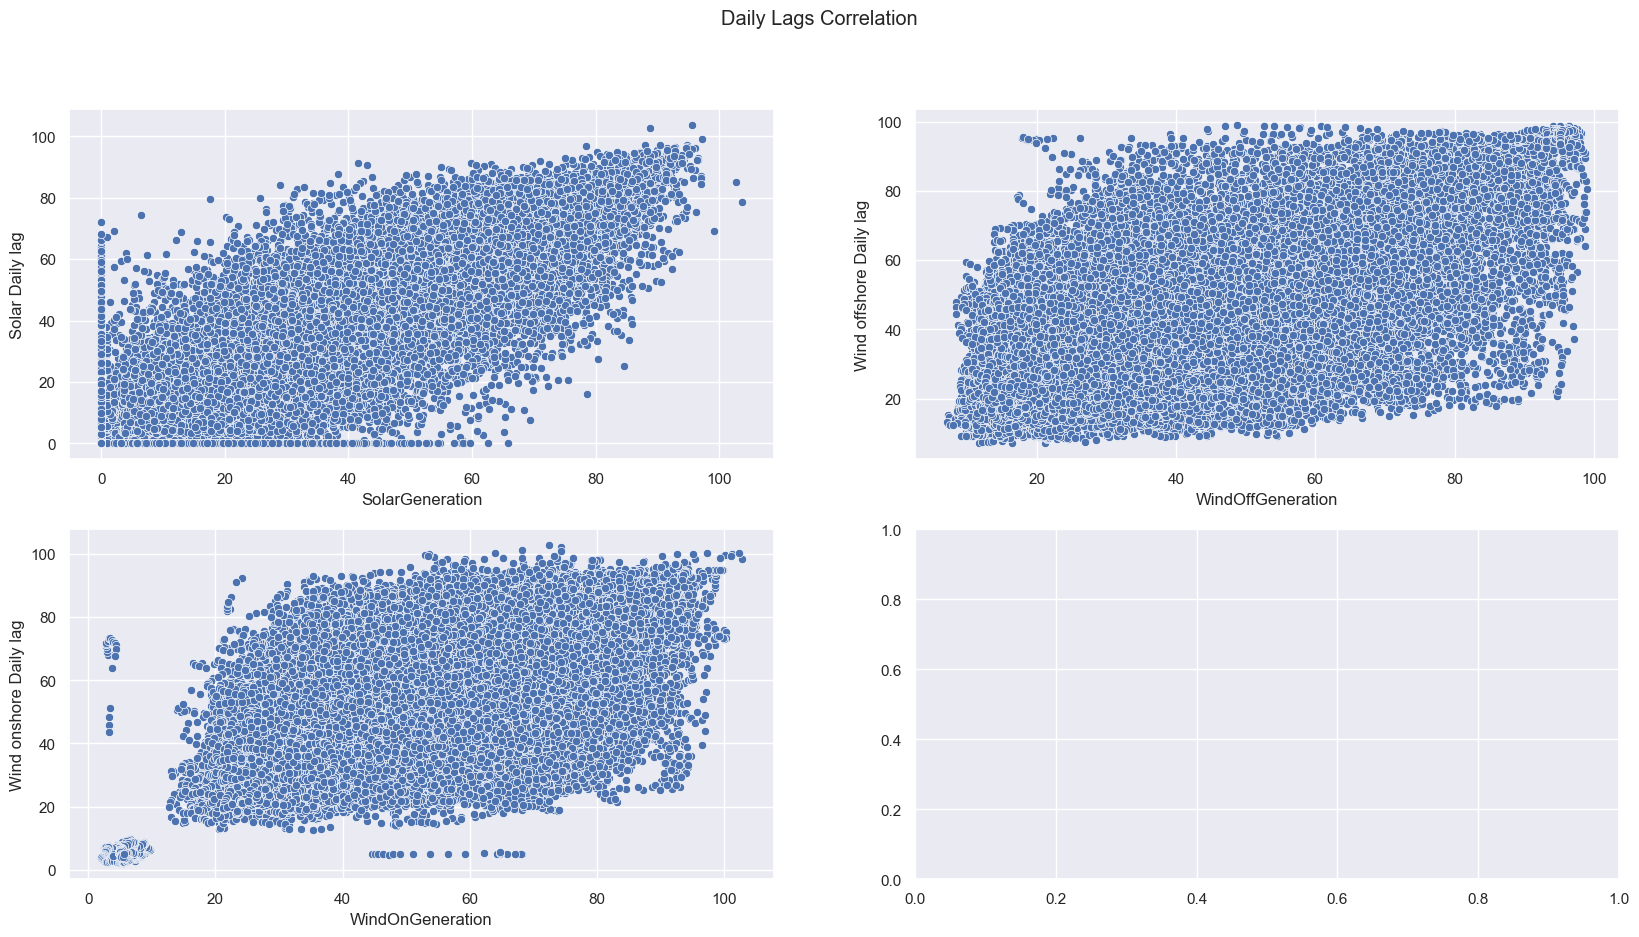

In [100]:
fig , axs = plt.subplots(2,2)
fig.suptitle("Daily Lags Correlation")
sns.scatterplot(x=df_model['SolarGeneration'], y=df_model['Solar Daily lag'], ax=axs[0,0])
sns.scatterplot(x=df_model['WindOffGeneration'], y=df_model['Wind offshore Daily lag'], ax=axs[0,1])
sns.scatterplot(x=df_model['WindOnGeneration'], y=df_model['Wind onshore Daily lag'], ax=axs[1,0])


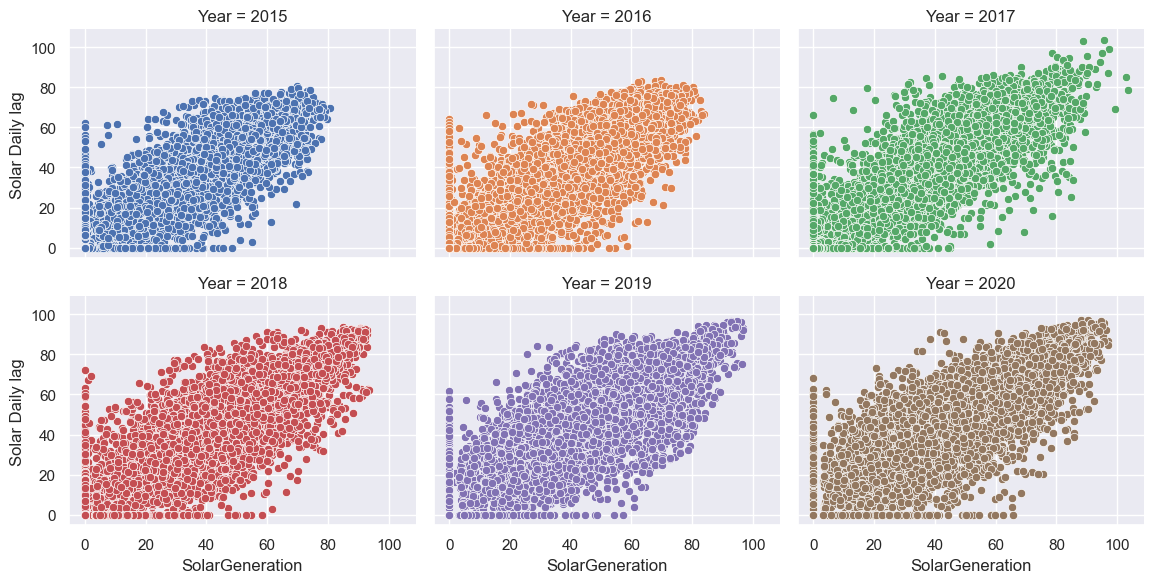

In [101]:
ax = sns.FacetGrid(df_model, col='Year', hue='Year', aspect=1.3, col_wrap=3)
ax.map(sns.scatterplot, "SolarGeneration", "Solar Daily lag")

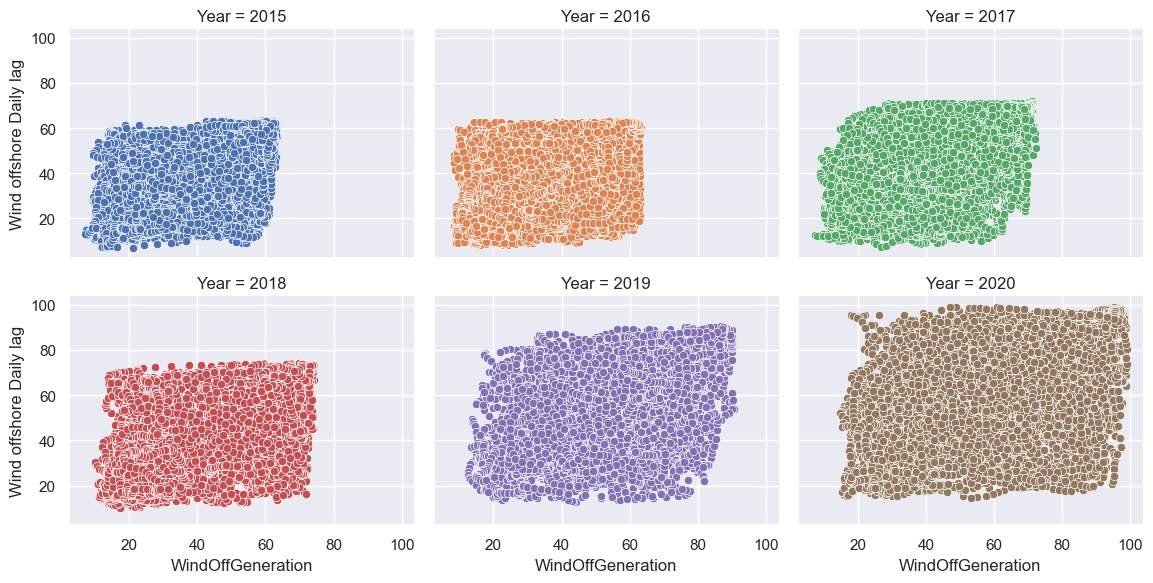

In [102]:
ax = sns.FacetGrid(df_model, col='Year', hue='Year', aspect=1.3, col_wrap=3)
ax.map(sns.scatterplot, "WindOffGeneration", "Wind offshore Daily lag")

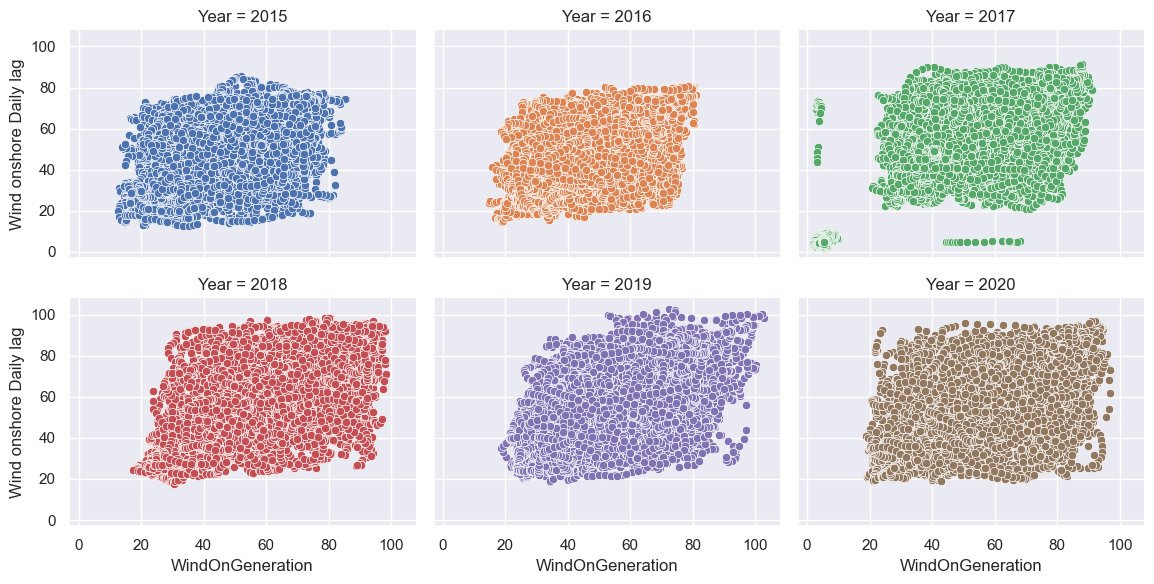

In [103]:
ax = sns.FacetGrid(df_model, col='Year', hue='Year', aspect=1.3, col_wrap=3)
ax.map(sns.scatterplot, "WindOnGeneration", "Wind onshore Daily lag")

## Weekly Lags

<AxesSubplot:xlabel='WindOnGeneration', ylabel='Wind onshore Weekly lag'>

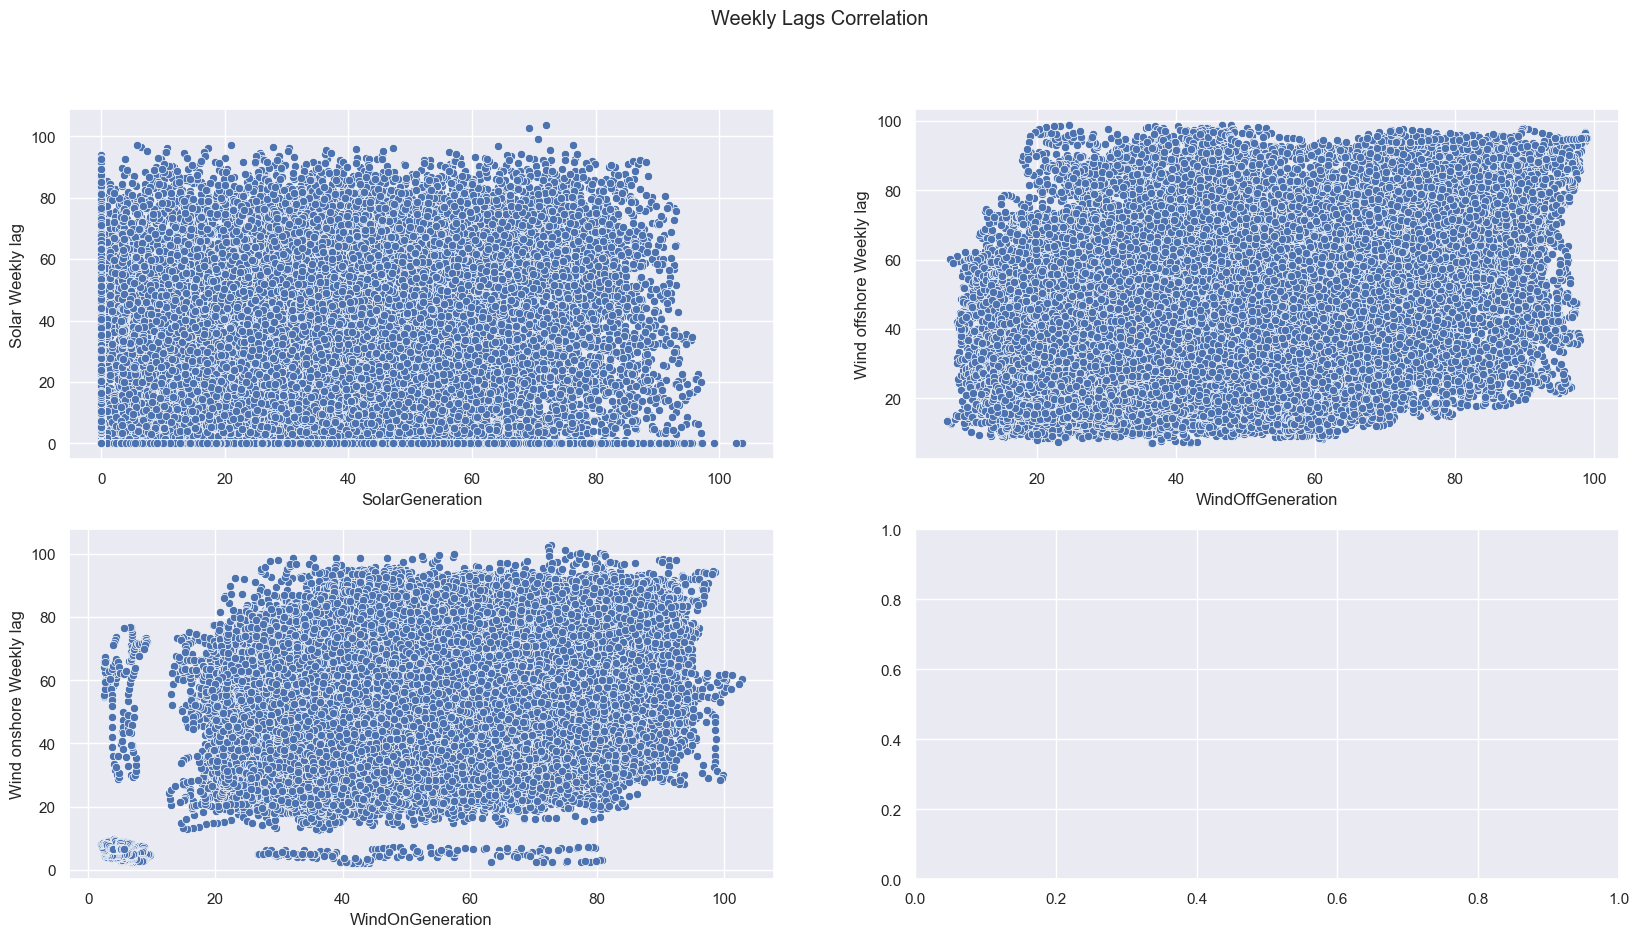

In [104]:
fig , axs = plt.subplots(2,2)
fig.suptitle("Weekly Lags Correlation")
sns.scatterplot(x=df_model['SolarGeneration'], y=df_model['Solar Weekly lag'], ax=axs[0,0])
sns.scatterplot(x=df_model['WindOffGeneration'], y=df_model['Wind offshore Weekly lag'], ax=axs[0,1])
sns.scatterplot(x=df_model['WindOnGeneration'], y=df_model['Wind onshore Weekly lag'], ax=axs[1,0])


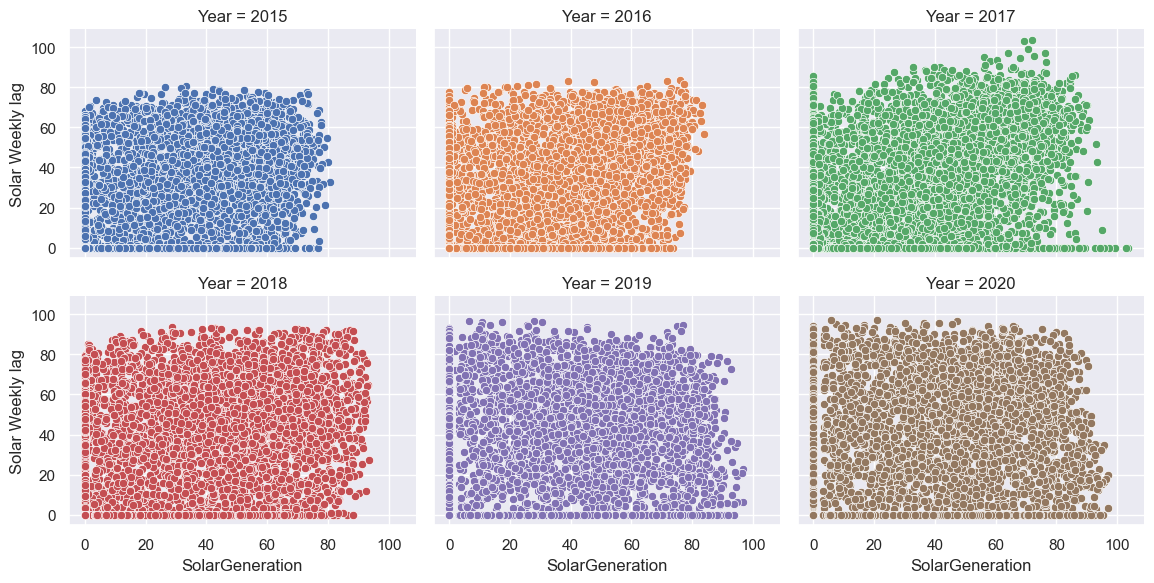

In [105]:
ax = sns.FacetGrid(df_model, col='Year', hue='Year', aspect=1.3, col_wrap=3)
ax.map(sns.scatterplot, "SolarGeneration", "Solar Weekly lag")

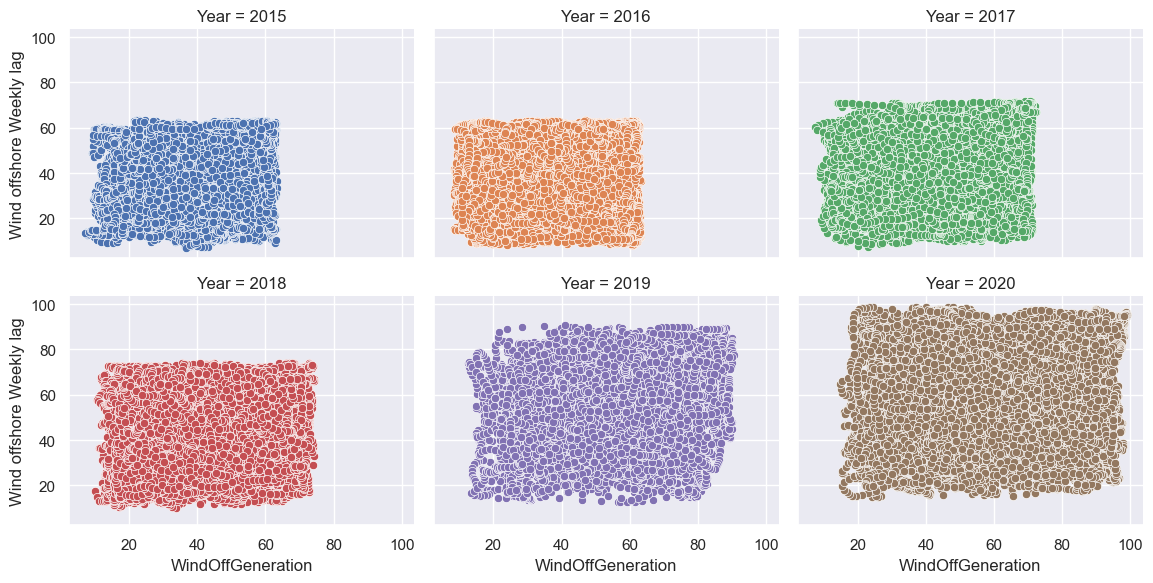

In [106]:
ax = sns.FacetGrid(df_model, col='Year', hue='Year', aspect=1.3, col_wrap=3)
ax.map(sns.scatterplot, "WindOffGeneration", "Wind offshore Weekly lag")

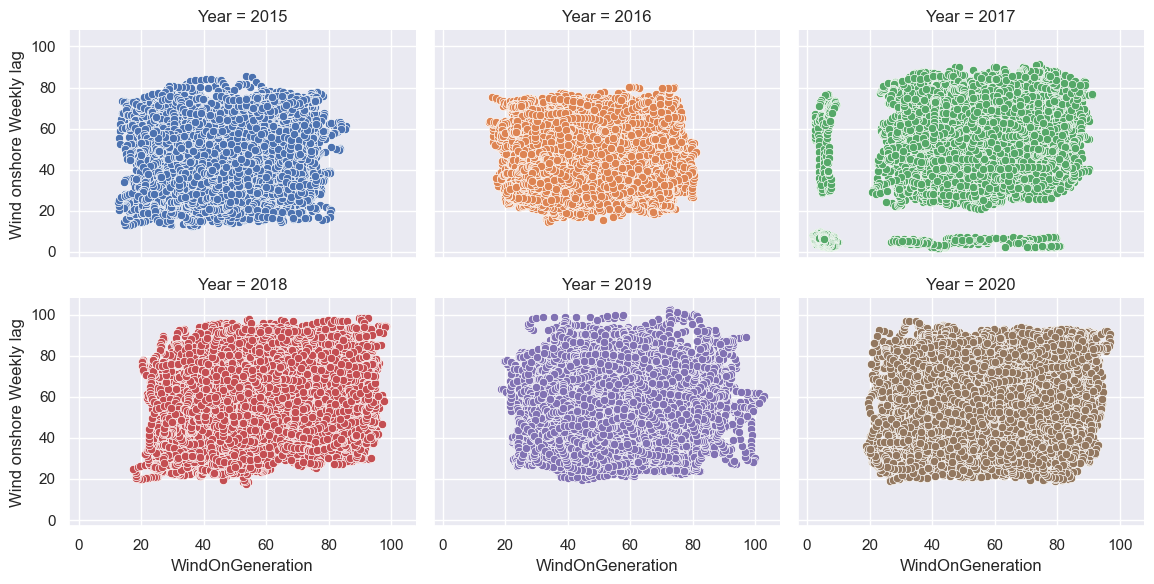

In [107]:
ax = sns.FacetGrid(df_model, col='Year', hue='Year', aspect=1.3, col_wrap=3)
ax.map(sns.scatterplot, "WindOnGeneration", "Wind onshore Weekly lag")